In [14]:
import os
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import tensorflow as tf

In [15]:
path = os.path.abspath(os.getcwd())+'\\resultados\\'

# Guardamos la configuracion del NumPy np.load
np_load_old = np.load

# Modificamos un parametro del np.load por defecto que no permitia realizar la descarga
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

train_data = np.load(path+'train_data.npy')
train_labels = np.load(path+'train_labels.npy')
test_data = np.load(path+'test_data.npy')
test_labels = np.load(path+'test_labels.npy')
labels = np.load(path+'labels.npy')

# Restauramo np.load para su futuro uso regular
np.load = np_load_old

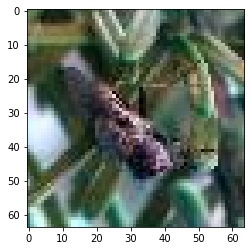

In [24]:
# Veamos una muestra
plt.imshow(train_data[2]);

In [4]:
bs = 200
nb_classes = 200
nb_epoch = 10

# input image dimensions
img_rows, img_cols = 64, 64
# The images are RGB
img_channels = 3

input_shape = (img_rows, img_cols, img_channels)

# The data, shuffled and split between train and test sets:
X_train = train_data
Y_train = train_labels
X_test = test_data
Y_test = test_labels
del train_data
del train_labels
del test_data
del test_labels
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, ReLU, Flatten, Dense
from tensorflow.keras.optimizers import SGD

def create_model():
  K.clear_session()

  input_layer = Input(shape=(64, 64, 3))
  convolutional_1 = Conv2D(16, kernel_size=3, padding="same")(input_layer)
  max_pooling_1 = MaxPool2D(2)(convolutional_1)
  relu_1 = ReLU()(max_pooling_1)
  convolutional_2 = Conv2D(32, kernel_size=3, padding="same")(relu_1)
  max_pooling_2 = MaxPool2D(2)(convolutional_2)
  relu_2 = ReLU()(max_pooling_2)
  convolutional_3 = Conv2D(64, kernel_size=3)(relu_2)
  relu_3 = ReLU()(convolutional_3)
  flatten = Flatten()(relu_3)
  dense = Dense(256, activation="relu")(flatten)
  output_layer = Dense(200, activation="softmax")(dense)

  model = Model(inputs=input_layer, outputs=output_layer)

  return model

In [6]:
def show_results(log):
  val_loss = log.history['val_loss']
  val_acc = log.history['val_accuracy']
      
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes
  ax1.plot(log.history['loss'], label='train')
  ax1.plot(val_loss, label='test')
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  ax2.plot(log.history['accuracy'], label='train')
  ax2.plot(val_acc, label='test')
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  for ax in axes: ax.legend()

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "models/model"

monitor = "val_accuracy"

mode = "max"

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor=monitor, verbose=1, save_best_only=True, save_weights_only=True, mode=mode)

In [8]:
lr = 0.001
momentum = 0.9

model = create_model()

model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy'])
# La función de pérdida 'sparse_categorical_crossentropy' realiza automaticamente la conversión
# del target a one-hot encoding.

## Agregamos un canal a los datos

In [9]:
X_train = X_train.reshape((-1, 64, 64, 3))
X_test = X_test.reshape((-1, 64, 64, 3))

# Validamos el tamaño del dataset
print( "train data shape: ",  X_train.shape )
print( "train label shape: ", Y_train.shape )
print( "test data shape: ",   X_test.shape )
print( "test_labels.shape: ", Y_test.shape )

train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


In [10]:

dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

dataset_train = dataset_train.shuffle(buffer_size=100).batch(bs).prefetch(50)

In [11]:
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

dataset_test = dataset_test.batch(bs).prefetch(50)

In [12]:
epochs = 20

history = model.fit(dataset_train, batch_size=bs, epochs=epochs, validation_data=dataset_test, callbacks=[model_checkpoint])

Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 5.2884 - accuracy: 0.0070
Epoch 00001: val_accuracy improved from -inf to 0.00690, saving model to models\model
500/500 [==============================] - 171s 328ms/step - loss: 5.2884 - accuracy: 0.0070 - val_loss: 5.2699 - val_accuracy: 0.0069
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 5.2232 - accuracy: 0.0136
Epoch 00002: val_accuracy improved from 0.00690 to 0.01810, saving model to models\model
500/500 [==============================] - 166s 331ms/step - loss: 5.2232 - accuracy: 0.0136 - val_loss: 5.1499 - val_accuracy: 0.0181
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 5.0293 - accuracy: 0.0318
Epoch 00003: val_accuracy improved from 0.01810 to 0.04070, saving model to models\model
500/500 [==============================] - 162s 325ms/step - loss: 5.0293 - accuracy: 0.0318 - val_loss: 4.9311 - val_accuracy: 0.0407
Epoch 4/20
500/500 [=======================

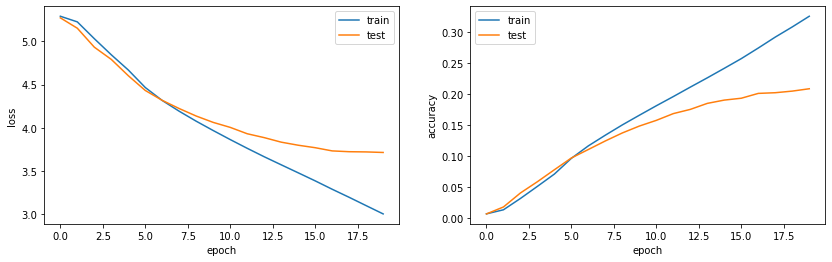

In [13]:
show_results(history)

## Modelo Inception

In [37]:

import cv2
new_shape = (224,224,3)
X_train_new = np.empty(shape=(X_train.shape[0],)+new_shape)
for idx in range(X_train.shape[0]):
    X_train_new[idx] = cv2.resize(X_train[idx], new_shape)


X_test_new = np.empty(shape=(X_test.shape[0],)+new_shape)
for idx in range(X_test.shape[0]):
    X_test_new[idx] = cv2.resize(X_test[idx], new_shape)

MemoryError: Unable to allocate 112. GiB for an array with shape (100000, 224, 224, 3) and data type float64

In [26]:
from keras.preprocessing.image import ImageDataGenerator
# For train and validation data
image_gen_aug = ImageDataGenerator(                                               
    samplewise_center=False,                                                
    rotation_range=30,                                                     
    width_shift_range=0.2, height_shift_range=0.2,                            
    brightness_range=(0.5,1.5),                                             
    shear_range=5,                                                          
    zoom_range=0.2,                                                         
    horizontal_flip=True,                                                    
    fill_mode='reflect',                                                    
    validation_split=0.1                                                  
)
# For the testing data (No augmentation)
image_gen = ImageDataGenerator(samplewise_center=False)

In [27]:
# Get training data generator
train_gen = image_gen_aug.flow(X_train, Y_train, batch_size=100)
# Get valid data generator
valid_gen = image_gen_aug.flow(X_test, Y_test, batch_size=100)
# Get test data generator
#test_gen = image_gen.flow(...)

In [28]:
def data_gen_augmented(gen, random_gamma=False, random_occlude=False):
    for x,y in gen: 
        if random_gamma:
            # Gamma correction
            # Doing this in the image process fn doesn't help improve performance
            rand_gamma = np.random.uniform(0.9, 1.08, (x.shape[0],1,1,1))
            x = x**rand_gamma
            
        if random_occlude:
            # Randomly occluding sections in the image
            occ_size = 10
            occ_h, occ_w = np.random.randint(0, x.shape[0]-occ_size), np.random.randint(0, x.shape[0]-occ_size)
            x[::2,occ_h:occ_h+occ_size,occ_w:occ_w+occ_size,:] = np.random.choice([0.,128.,255.])
        
        # Image centering
        x -= np.mean(x, axis=(1,2,3), keepdims=True)
        
        # Making sure we replicate the target (y) three times
        yield x,(y,y,y)

In [33]:
train_gen_aux = data_gen_augmented(train_gen, random_gamma=True, random_occlude=True)
# We do not augment data in the validation/test datasets
valid_gen_aux = data_gen_augmented(valid_gen)
#test_gen_aux = data_gen_augmented(test_gen)

In [36]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

K.clear_session()
# We're going to download the InceptionResNetv2 model, remove the top layer and wrap it around an input layer and a prediction layer (with 200 classes)
model = Sequential([
    Input(shape=(224,224,3)),
    InceptionResNetV2(include_top=False, pooling='avg'),
    Dropout(0.4),
    Dense(200, activation='softmax')
])
# Defining the loss
loss = tf.keras.losses.CategoricalCrossentropy()
# Defining the optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Compiling the model
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 200)               307400    
                                                                 
Total params: 54,644,136
Trainable params: 54,583,592
Non-trainable params: 60,544
_________________________________________________________________


In [34]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau
# Defining callbacks
es_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger(os.path.join('eval','4_eval_resnet_pretrained.log'))
n_epochs=50
batch_size = 100
lr_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
)
# Training the model
history = model.fit(
    train_gen_aux, 
    validation_data=valid_gen_aux, 
    steps_per_epoch=X_train.shape[0] // batch_size, 
    epochs=n_epochs, 
    callbacks=[es_callback, csv_logger, lr_callback]
)

Epoch 1/50


AttributeError: in user code:

    File "C:\Users\DAVID\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\DAVID\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\DAVID\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\DAVID\anaconda3\lib\site-packages\keras\engine\training.py", line 817, in train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\DAVID\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 439, in update_state
        self.build(y_pred, y_true)
    File "C:\Users\DAVID\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 359, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,
    File "C:\Users\DAVID\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 485, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\DAVID\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 485, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\DAVID\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 506, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    AttributeError: 'tuple' object has no attribute 'shape'
